In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os

## Extracting files

In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT-20240622T111748Z-001.zip'

extract_to = '/content/drive/MyDrive'
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Files extracted to {extract_to}')

Files extracted to /content/drive/MyDrive


In [ ]:
zip_file_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Licplatesdetection_train.zip'

extract_to = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT'
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Files extracted to {extract_to}')

Files extracted to /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT


In [ ]:
zip_file_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Licplatesrecognition_train.zip'

extract_to = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT'
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Files extracted to {extract_to}')

Files extracted to /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT


In [ ]:
zip_file_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test.zip'

extract_to = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT'
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Files extracted to {extract_to}')

Files extracted to /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT


## Exploring the .csv files

In [4]:
annotations = pd.read_csv('/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Licplatesdetection_train.csv')
annotations.head()

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [5]:
characters = pd.read_csv('/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/Licplatesrecognition_train.csv')
characters.head()

,img_id,text
0,0.jpg,117T3989
1,1.jpg,128T8086
2,10.jpg,94T3458
3,100.jpg,133T6719
4,101.jpg,68T5979


In [6]:
example = pd.read_csv('/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/SampleSubmission.csv')
example.head()

,id,0,1,2,3,4,5,6,7,8,9
0,img_901_1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,img_901_2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,img_901_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,img_901_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,img_901_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploring the images

Image Shape:  (477, 850, 3)


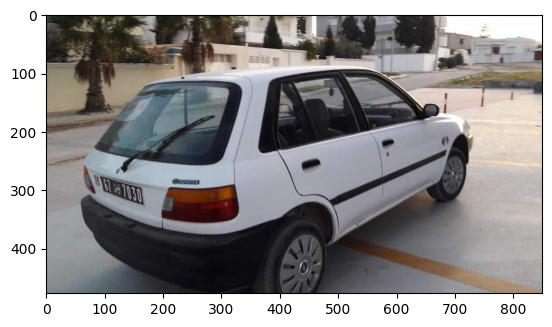

In [7]:
cv_img = cv2.imread(r"/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_detection_train/1.jpg")
print("Image Shape: ",cv_img.shape)
plt.imshow(cv_img[:, :, ::-1])

Image Shape:  (20, 89, 3)


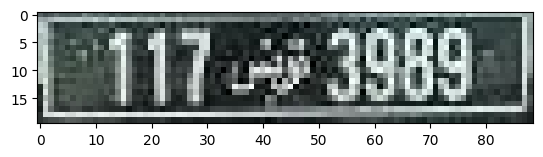

In [8]:
cv_img2 = cv2.imread(r"/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_recognition_train/0.jpg")
print("Image Shape: ",cv_img2.shape)
plt.imshow(cv_img2[:, :, ::-1])

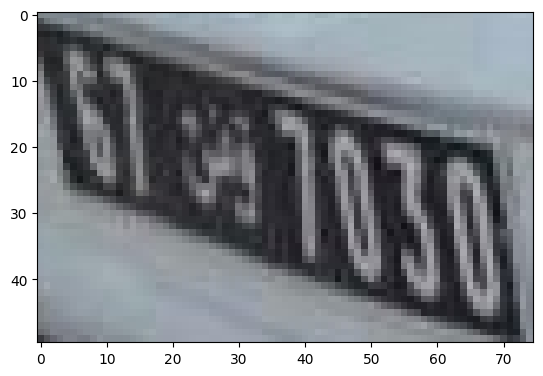

In [9]:
# Verifying Annotations.
img = cv_img
img = img[276:326,94:169]
plt.imshow(img[:, :, ::-1])

## Model Building: Object Detection - Preparing The Images

In [10]:
annotations.head()

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [11]:
def get_all_files_in_directory(directory):
    file_paths = []
    for root, directories, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)
    return sorted(file_paths)

directory_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_detection_train'
car_images = get_all_files_in_directory(directory_path)

matched_data = []
for img_path in car_images:
    filename = os.path.basename(img_path)
    annotation = annotations[annotations['img_id'] == filename]
    if not annotation.empty:
        bbox = annotation[['ymin', 'ymax', 'xmin', 'xmax']].values[0]
        matched_data.append((img_path, bbox))

image_paths = np.array([item[0] for item in matched_data])
image_annotations = np.array([item[1] for item in matched_data])

print(image_paths[0])
print(image_annotations[0])

/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_detection_train/1.jpg
[276 326  94 169]


In [12]:
print(image_paths[0:5])
print(image_annotations[0:5])

['/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_detection_train/1.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_detection_train/10.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_detection_train/100.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_detection_train/101.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_detection_train/102.jpg']
[[276 326  94 169]
 [311 344 395 444]
 [406 450 263 434]
 [283 315 363 494]
 [139 280  42 222]]


In [13]:
class LicensePlateDataset(Dataset):
    def __init__(self, image_paths, image_annotations, transform=None):
        self.image_paths = image_paths
        self.image_annotations = image_annotations
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        bbox = self.image_annotations[idx]

        ymin, ymax, xmin, xmax = bbox

        # Ensure bounding boxes have positive height and width
        if ymin >= ymax or xmin >= xmax:
            raise ValueError(f"Invalid bounding box {bbox} for image {img_path}")

        if self.transform:
            img = self.transform(img)

        target = {}
        bbox_array = np.array([[xmin, ymin, xmax, ymax]], dtype=np.float32)
        target['boxes'] = torch.tensor(bbox_array)
        target['labels'] = torch.tensor([1], dtype=torch.int64)  # Assuming all labels are '1' for license plates

        return img, target

transform = transforms.Compose([
    transforms.ToTensor()])

dataset = LicensePlateDataset(image_paths, image_annotations, transform=transform)

# Create a data loader
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [14]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 1 class (license plate) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the device (GPU/CPU)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 5

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 75.0MB/s]


## Object Detection - Model Training

In [ ]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(data_loader)}')

model.eval()
with torch.no_grad():
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        predictions = model(images)

        for i, prediction in enumerate(predictions):
            print(f'Image {i+1}:', prediction)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.95 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss: 0.07615862372848722
Epoch 2, Loss: 0.03915816918843322
Epoch 3, Loss: 0.035831901422805255
Epoch 4, Loss: 0.030199888588653672
Epoch 5, Loss: 0.028344693370163442
Image 1: {'boxes': tensor([[550.3762, 358.7343, 677.9983, 430.7127]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}
Image 2: {'boxes': tensor([[126.0851, 345.3253, 289.3150, 381.6010]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}
Image 3: {'boxes': tensor([[119.6156, 385.4326, 279.8712, 417.9468]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}
Image 4: {'boxes': tensor([[132.4073, 287.3945, 251.0576, 358.6125]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}
Image 1: {'boxes': tensor([[113.6207, 190.7163, 218.6503, 220.5956]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

## Trying the model out on the test set

In [16]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define the model architecture
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 1 class (license plate) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Define the path to the saved model
model_load_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plate_detection_model.pth'

# Load the model's state dictionary, mapping it to CPU if CUDA is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(model_load_path, map_location=device))

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

# Set the model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

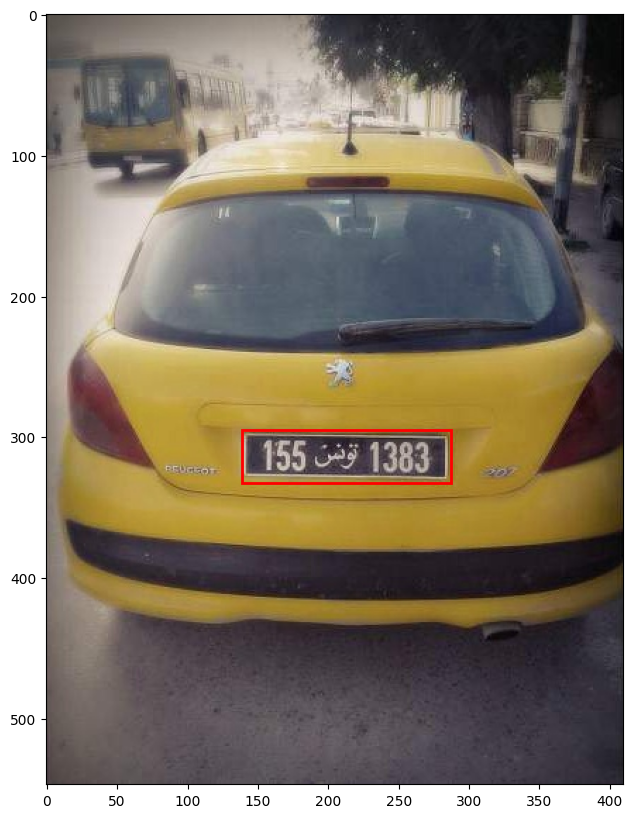

In [17]:
# Inference
def predict(model, image_path, transform, device, threshold=0.5):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_transformed = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img_transformed)

    prediction = prediction[0]
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    # Filter out low-confidence predictions
    valid_boxes = boxes[scores >= threshold]

    return valid_boxes, img

def visualize_predictions(image_path, boxes):
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    ax = plt.gca()
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Make predictions on a sample image
sample_image_path = image_paths[60]  # You can change this to any image path from the dataset
boxes, img = predict(model, sample_image_path, transform, device)

# Visualize the predictions
visualize_predictions(sample_image_path, boxes)

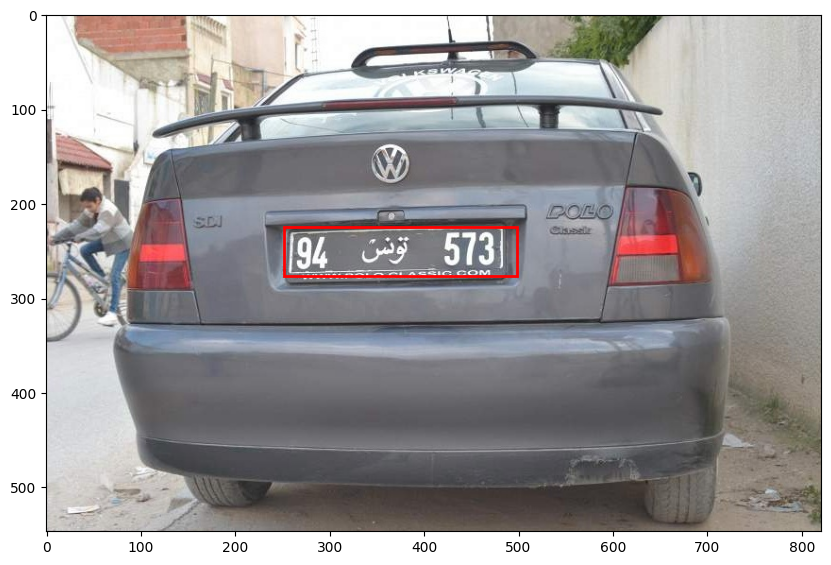

In [18]:
sample_image_path = "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1000.jpg"
boxes, img = predict(model, sample_image_path, transform, device)

# Visualize the predictions
visualize_predictions(sample_image_path, boxes)

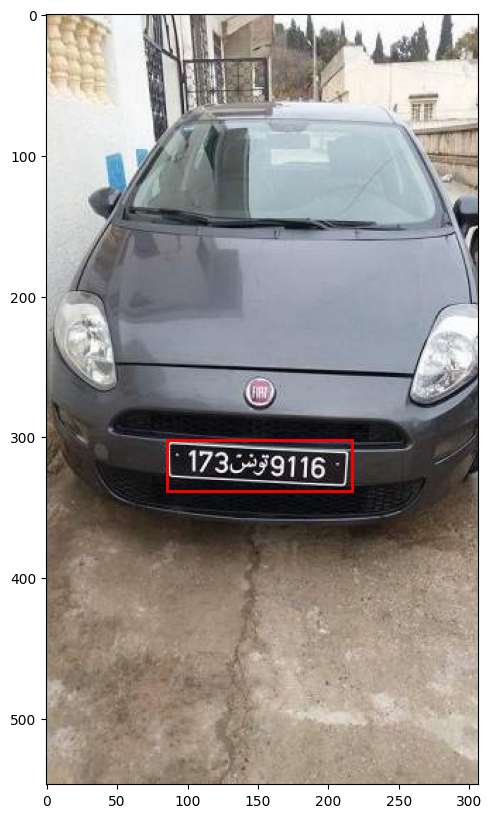

In [19]:
sample_image_path = "/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1001.jpg"
boxes, img = predict(model, sample_image_path, transform, device)

# Visualize the predictions
visualize_predictions(sample_image_path, boxes)

## Saving the object detection model

In [22]:
# Define the path where you want to save the model
model_save_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plate_detection_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

## Character Recognition Model

In [20]:
directory_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test'
test_car_images = get_all_files_in_directory(directory_path)

In [21]:
test_car_images = np.array(test_car_images)
print(test_car_images[0:5])

['/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1000.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1001.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1002.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1003.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1004.jpg']


## Extracting the License Plate Images from the test set

In [ ]:
# Function to extract and save license plates
def extract_and_save_license_plates(model, image_paths, transform, device, save_dir, threshold=0.5):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i, image_path in enumerate(image_paths):
        boxes, img = predict(model, image_path, transform, device, threshold)

        # Get the base file name without extension
        base_filename = os.path.splitext(os.path.basename(image_path))[0]

        for j, box in enumerate(boxes):
            xmin, ymin, xmax, ymax = map(int, box)
            license_plate = img.crop((xmin, ymin, xmax, ymax))

            # Save the license plate with a unique file name including the original image file name
            license_plate.save(os.path.join(save_dir, f'{base_filename}_license_plate_{j}.jpg'))

# Define the directory to save the extracted license plates
save_dir = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates'
extract_and_save_license_plates(model, test_car_images, transform, device, save_dir)

Image Shape:  (547, 821, 3)


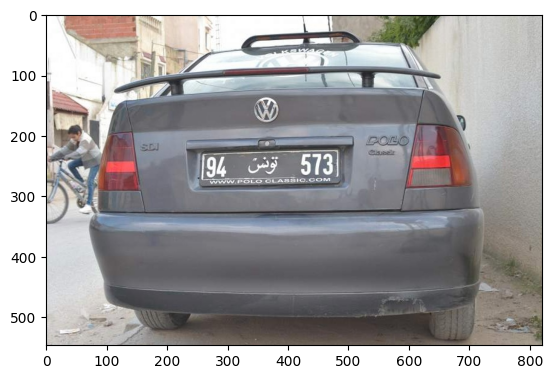

In [22]:
plate_img = cv2.imread(r"/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test/1000.jpg")
print("Image Shape: ",plate_img.shape)
plt.imshow(plate_img[:, :, ::-1])

Image Shape:  (51, 247, 3)


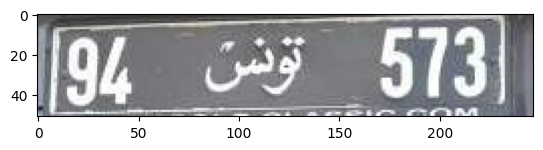

In [23]:
plate_img = cv2.imread(r"/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/1000_license_plate_0.jpg")
print("Image Shape: ",plate_img.shape)
plt.imshow(plate_img[:, :, ::-1])

## Training a Character Recognition Model

#### Filtering out Images without License Plates

In [24]:
files_count_1 = len(os.listdir("/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates"))
files_count_2 = len(os.listdir("/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test"))
print("Extracted License Plates: ",files_count_1)
print("Original License Plates Images: ",files_count_2)

Extracted License Plates:  210
Original License Plates Images:  210


In [ ]:
directory_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates'

count = 0

files = os.listdir(directory_path)

# Iterating through the files and count those that end with '1.jpg'
for file in files:
    if file.endswith('1.jpg'):
        count += 1

print(f"Number of files ending with '1.jpg' in '{directory_path}': {count}")

Number of files ending with '1.jpg' in '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates': 11


In [ ]:
directory_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates'

files = os.listdir(directory_path)

# Filter files that end with "1.jpg"
files_to_delete = [file for file in files if file.endswith('1.jpg')]

# Iterate over files and delete them
for file in files_to_delete:
    file_path = os.path.join(directory_path, file)
    os.remove(file_path)
    print(f'Deleted: {file_path}')

Deleted: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/1015_license_plate_1.jpg
Deleted: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/1039_license_plate_1.jpg
Deleted: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/1052_license_plate_1.jpg
Deleted: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/1074_license_plate_1.jpg
Deleted: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/1090_license_plate_1.jpg
Deleted: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/902_license_plate_1.jpg
Deleted: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/904_license_plate_1.jpg
Deleted: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/911_license_plate_1.jpg
Deleted: /content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/918_license_plate_1.jpg
Deleted: /content/drive/MyDrive/

In [25]:
files_count_1 = len(os.listdir("/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates"))
files_count_2 = len(os.listdir("/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/test/test"))
print("Extracted License Plates: ",files_count_1)
print("Original License Plates Images: ",files_count_2)

Extracted License Plates:  210
Original License Plates Images:  210


## Character Recognition

### Verifiying labels for character recognition

In [26]:
characters.head()

,img_id,text
0,0.jpg,117T3989
1,1.jpg,128T8086
2,10.jpg,94T3458
3,100.jpg,133T6719
4,101.jpg,68T5979


In [27]:
# Removing all alphabets, leaving only numbers
characters['text'] = characters['text'].str.replace(r'[a-zA-Z]', '', regex=True)

In [28]:
characters.head()

,img_id,text
0,0.jpg,1173989
1,1.jpg,1288086
2,10.jpg,943458
3,100.jpg,1336719
4,101.jpg,685979


Image Shape:  (20, 89, 3)


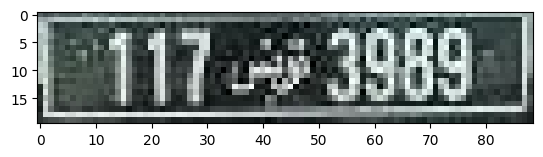

In [30]:
plate_img = cv2.imread(r"/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_recognition_train/0.jpg")
print("Image Shape: ",plate_img.shape)
plt.imshow(plate_img[:, :, ::-1])

In [31]:
def get_all_files_in_directory(directory):
    file_paths = []
    for root, directories, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)
    return sorted(file_paths)

directory_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_recognition_train'
plate_images = get_all_files_in_directory(directory_path)

matched_data = []
for img_path in plate_images:
    filename = os.path.basename(img_path)
    annotation = characters[characters['img_id'] == filename]
    if not annotation.empty:
        bbox = annotation['text'].values[0]
        matched_data.append((img_path, bbox))

image_paths = np.array([item[0] for item in matched_data])
image_annotations = np.array([item[1] for item in matched_data])

print(image_paths[0])
print(image_annotations[0])

/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_recognition_train/0.jpg
1173989


In [32]:
print(len(image_paths))
print(len(image_annotations))

900
900


## Building Dataset for the Character Recognition Model

In [33]:
print(image_paths[0:5])
print(image_annotations[0:5])

['/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_recognition_train/0.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_recognition_train/1.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_recognition_train/10.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_recognition_train/100.jpg'
 '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_recognition_train/101.jpg']
['1173989' '1288086' '943458' '1336719' '685979']


In [34]:
# Function to load and preprocess images using cv2
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    image = cv2.resize(image, (128, 128),interpolation=cv2.INTER_AREA)  # Resize to a fixed size
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add channel dimension
    return image

# Load images and labels
images = []
labels = []

for index, row in characters.iterrows():
    image_path = os.path.join('/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plates_recognition_train', row['img_id'])
    label = row['text']
    images.append(load_and_preprocess_image(image_path))
    labels.append([int(digit) for digit in label])

images = np.array(images)

# Ensure all labels have the same length by padding with zeros
max_length = max(len(label) for label in labels)
labels = np.array([label + [0]*(max_length - len(label)) for label in labels])

In [35]:
images[0].shape

(1, 128, 128)

In [36]:
labels[0]

array([1, 1, 7, 3, 9, 8, 9])

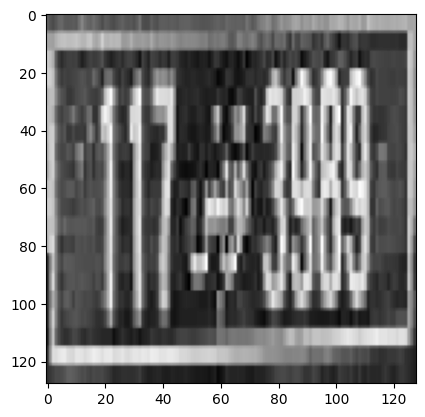

In [37]:
import matplotlib.pyplot as plt

# Visualize one of the images to ensure correct loading
def visualize_image(images, index=0):
    image = images[index].squeeze()  # Remove the channel dimension
    plt.imshow(image, cmap='gray')
    plt.show()

visualize_image(images, index=0)

In [38]:
class LicensePlateDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create dataset and dataloader
dataset = LicensePlateDataset(images, labels)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

### Training Character Recognition Model

In [176]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# Modify the first convolution layer to accept single-channel (grayscale) input
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer to output max_length * 10 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, max_length * 10)

model = resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [177]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Flatten labels and outputs for calculating loss
        labels = labels.view(-1)
        outputs = outputs.view(-1, 10)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(data_loader)}')

print('Finished Training')

Epoch [1/10], Loss: 2.1899416528899094
Epoch [2/10], Loss: 1.9428913798825493
Epoch [3/10], Loss: 1.7352608401199867
Epoch [4/10], Loss: 1.4671985198711526
Epoch [5/10], Loss: 1.1976588594502415
Epoch [6/10], Loss: 0.9523286860564659
Epoch [7/10], Loss: 0.6634608085813194
Epoch [8/10], Loss: 0.4311003931637468
Epoch [9/10], Loss: 0.2908348723732192
Epoch [10/10], Loss: 0.2024679009256692
Finished Training


In [178]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plate_recognition_model.pth')

## Loading the Saved-Trained Model for Inference

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ResNet model
resnet = models.resnet18()

# Modify the first convolution layer to accept single-channel (grayscale) input
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer to output max_length * 10 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, max_length * 10)

model = resnet.to(device)

# Load the trained model weights
model.load_state_dict(torch.load('/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/license_plate_recognition_model.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    image = cv2.resize(image, (128, 128))  # Resize to a fixed size
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add channel dimension
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return torch.tensor(image, dtype=torch.float32)

def predict(model, image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        outputs = model(image_tensor)

    # Reshape output to separate digits
    outputs = outputs.view(max_length, 10)
    _, predicted_digits = torch.max(outputs, 1)

    # Convert predicted digits to list
    predicted_digits = predicted_digits.cpu().numpy().tolist()
    return predicted_digits

# Preprocess a single image
image_path = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/1001_license_plate_0.jpg'  # Change to the path of your image
image_tensor = preprocess_image(image_path)

# Run inference
predicted_digits = predict(model, image_tensor)

# Print the predicted digits
print('Predicted digits:', predicted_digits)

Predicted digits: [1, 7, 3, 9, 1, 1, 6]


Image Shape:  (36, 131, 3)


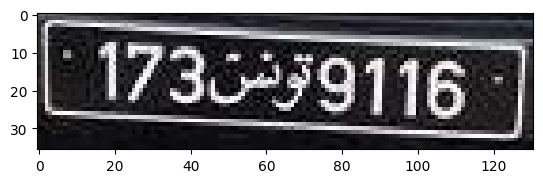

In [41]:
plate_img = cv2.imread(r"/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates/1001_license_plate_0.jpg")
print("Image Shape: ",plate_img.shape)
plt.imshow(plate_img[:, :, ::-1])

In [42]:
image_dir = '/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/extracted_license_plates'

# Get a list of all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Run inference on each image and store results
results = []

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    image_tensor = preprocess_image(image_path)
    predicted_digits = predict(model, image_tensor)
    results.append([image_file] + predicted_digits)

# Create a DataFrame from the results
columns = ['id'] + [str(i) for i in range(max_length)]
results_df = pd.DataFrame(results, columns=columns)

# Save the results to a CSV file
results_df.to_csv('/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/predicted_results.csv', index=False)

print('Inference completed and results saved to predicted_results.csv')

Inference completed and results saved to predicted_results.csv


In [43]:
results_df.head()

,id,0,1,2,3,4,5,6
0,1000_license_plate_0.jpg,9,4,5,7,3,0,0
1,1001_license_plate_0.jpg,1,7,3,9,1,1,6
2,1002_license_plate_0.jpg,7,1,1,5,2,4,0
3,1003_license_plate_0.jpg,8,5,9,8,9,5,0
4,1004_license_plate_0.jpg,7,8,1,2,1,0,0


In [44]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      210 non-null    object
 1   0       210 non-null    int64 
 2   1       210 non-null    int64 
 3   2       210 non-null    int64 
 4   3       210 non-null    int64 
 5   4       210 non-null    int64 
 6   5       210 non-null    int64 
 7   6       210 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 13.2+ KB


## Final Output!

In [46]:
# Convert to binary row-wise format
binary_results = []

for index, row in results_df.iterrows():
    for pos, digit in enumerate(row[1:]):
        binary_row = [f"{row['id']}_{pos + 1}"]
        binary_digits = [0] * 10
        if digit < 10:  # Ensure valid digit
            binary_digits[digit] = 1
        binary_row.extend(binary_digits)
        binary_results.append(binary_row)

# Create the appropriate column names
binary_columns = ['id'] + [str(i) for i in range(10)]

# Create a DataFrame from the binary results
binary_df = pd.DataFrame(binary_results, columns=binary_columns)

print('Inference completed and binary row-wise results saved to binary_predicted_results_rowwise.csv')

Inference completed and binary row-wise results saved to binary_predicted_results_rowwise.csv


In [48]:
binary_df.head(14)

,id,0,1,2,3,4,5,6,7,8,9
0,1000_license_plate_0.jpg_1,0,0,0,0,0,0,0,0,0,1
1,1000_license_plate_0.jpg_2,0,0,0,0,1,0,0,0,0,0
2,1000_license_plate_0.jpg_3,0,0,0,0,0,1,0,0,0,0
3,1000_license_plate_0.jpg_4,0,0,0,0,0,0,0,1,0,0
4,1000_license_plate_0.jpg_5,0,0,0,1,0,0,0,0,0,0
5,1000_license_plate_0.jpg_6,1,0,0,0,0,0,0,0,0,0
6,1000_license_plate_0.jpg_7,1,0,0,0,0,0,0,0,0,0
7,1001_license_plate_0.jpg_1,0,1,0,0,0,0,0,0,0,0
8,1001_license_plate_0.jpg_2,0,0,0,0,0,0,0,1,0,0
9,1001_license_plate_0.jpg_3,0,0,0,1,0,0,0,0,0,0


In [49]:
# Save the binary results to a CSV file
binary_df.to_csv('/content/drive/MyDrive/DATA SCIENTIST_ASSIGNMENT/binary_predicted_results_rowwise.csv', index=False)